In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [22]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [7]:
def load_subj_behav_data(subj):
    behav_data = pd.read_csv(os.path.join(
        DEFAULT_FEATURE_FOLDER, str(subj), 'behavior.csv'), index_col=0)
    return behav_data

In [ ]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'behavior', 'behavior_bias')

## Load data

In [10]:
def load_all_behav_data():
    dfs = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        dfs.append(behav_data)
    loaded = pd.concat(dfs)
    loaded = loaded.reset_index(drop=True)
    return loaded

In [11]:
behavioral_df = load_all_behav_data()
behavioral_df.head()

,participant,mode,sample_stage,stim_sample_method,block,trial,trial_code,ITI,stim_1,stim_region_1,...,err_1,resp_2,resp_2_n_attempts,resp_2_last_drawing_tstart,resp_2_last_drawing_tend,resp_2_last_drawing_t,resp_2_last_drawing_curv,err_2,current_last_response,prev_last_response
0,908,draw,0,mixed,0,0,0,1.466436,53.768502,1.0,...,0.231498,NaN,0,NaN,NaN,NaN,NaN,NaN,54.0,NaN
1,908,draw,0,mixed,0,1,0,2.577546,95.392638,2.0,...,11.607362,148.0,1,6.895704,9.128985,2.233281,1.119698,2.773095,148.0,54.0
2,908,draw,0,mixed,0,2,0,1.757377,169.828842,3.0,...,-6.828842,NaN,0,NaN,NaN,NaN,NaN,NaN,163.0,148.0
3,908,draw,0,mixed,0,3,0,1.932901,59.178761,1.0,...,-6.178761,35.0,1,7.544835,9.711595,2.166760,1.252607,-1.973983,53.0,163.0
4,908,draw,0,mixed,0,4,0,1.512830,114.967475,2.0,...,NaN,169.0,1,1.995037,6.494834,4.499797,0.984687,-4.183743,169.0,53.0


##### Reorganize the data (one stim per row)

In [37]:
def reorganize_loaded_behav_df(df):
    had_two_resps = (~(df['resp_1'].isna() | df['resp_2'].isna())).to_numpy()
    all_order_codes = np.zeros((len(df), 2), dtype=int)
    stim1_done_first = (
        df['resp_1_last_drawing_tend'] > df['resp_2_last_drawing_tstart']).to_numpy()
    all_order_codes[had_two_resps&stim1_done_first, 0] = 1
    all_order_codes[had_two_resps&(~stim1_done_first), 0] = 2
    all_order_codes[had_two_resps&stim1_done_first, 1] = 2
    all_order_codes[had_two_resps&(~stim1_done_first), 1] = 1

    stims = np.concatenate([
        df['stim_1'].values, 
        df['stim_2'].values,
    ])
    neighbor_stims = np.concatenate([
        df['stim_2'].values,
        df['stim_1'].values,
    ])
    resps = np.concatenate([
        df['resp_1'].values,
        df['resp_2'].values,
    ])
    selected_ids = np.concatenate([
        np.ones(len(df), dtype=int),
        np.ones(len(df), dtype=int) * 2,
    ])
    order_codes = np.concatenate([
        all_order_codes[:, 0],
        all_order_codes[:, 1],
    ])

    df_copy = pd.concat([
        df.copy(),
        df.copy(),
    ], ignore_index=True)
    df_copy['stim'] = stims
    df_copy['neighbor_stim'] = neighbor_stims
    df_copy['resp'] = resps
    df_copy['selected_id'] = selected_ids
    df_copy['order_code'] = order_codes

    # filtering
    df_copy = df_copy[~(df_copy['resp'].isna())]
    return df_copy

In [39]:
reorganized = reorganize_loaded_behav_df(behavioral_df)

## Plot all biases

In [24]:
from utils.behav_plotting import (
    smart_diff, plot_binned_impact, get_binned_impact_data
)

PLOT_SAMPLE_WIDTH = 6
PLOT_BIN_WIDTH = 10

# copy from the original comparison notebook
def plot_curves(ax, xs, ys, 
        max_y, min_n_points,
        n_flip, always_pos, label,
        stat_type, stat_plot_type):
    # for cardinal, we still want to separate 0-45 and 45-90
    plot_n_flip = n_flip
    if n_flip == 2:
        plot_n_flip = 1
    
    # plot data
    if stat_plot_type == 'mean':
        binned_data = plot_binned_impact(
            ax, xs, ys, 
            max_y, min_n_points,
            plot_n_flip, always_pos, label,
            bin_width=PLOT_BIN_WIDTH, sample_width=PLOT_SAMPLE_WIDTH)
    elif stat_plot_type == 'sd':
        binned_data = get_binned_impact_data(
            xs, ys, 
            max_y, min_n_points,
            plot_n_flip, always_pos,
            bin_width=PLOT_BIN_WIDTH//2, sample_width=PLOT_SAMPLE_WIDTH)
        ys_sd = [np.sqrt(np.var(y)) for y in binned_data['y']]
        ax.plot(binned_data['x'], ys_sd, label=label)
    else:
        raise NotImplementedError(f'Unknown stat plot type {stat_plot_type}')
    return binned_data

In [25]:
def plot_bias_curve(ax, df, mask_lambda, x1, x2, y1, y2, label=None):
    mask = mask_lambda(df)
    df = df[mask]
    xs = smart_diff(df[x1], df[x2])
    ys = smart_diff(df[y1], df[y2])
    binned_data = plot_curves(
        ax, xs, ys, max_y=45, min_n_points=3,
        n_flip=1, always_pos=False, label=label,
        stat_type='bias', stat_plot_type='mean')
    
    y_lim = [-12, 12]
    ax.set_ylim(y_lim)
    y_label_text = 'error'
    ax.set_ylabel(y_label_text)
    ax.set_xlim([0, 90])
    ax.axvline(0, color='y', linestyle='--')
    ax.axhline(0, color='y', linestyle='--')
    
    return binned_data

## specify conditions to compare 

In [26]:
from collections import OrderedDict

all_conditions_to_compare = OrderedDict()

all_conditions_to_compare['compare different modes'] = OrderedDict([
    (
        'all',
        {
            'draw': lambda d: ((d['mode']=='draw') & (d['trial_code'].isin([0, 1]))).to_numpy(),
            'click': lambda d: ((d['mode']=='click') & (d['trial_code'].isin([0, 1]))).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when know what to report'] = OrderedDict([
    (
        'report 1 v.s. 1st response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 1st response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when both are to be reported'] = OrderedDict([
    (
        '1st response (draw)',
        {
            'know': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        '2nd response (draw)',
        {
            'know': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        '1st response (click)',
        {
            'know': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        '2nd response (click)',
        {
            'know': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
            'unknow': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['when unknow what to report'] = OrderedDict([
    (
        'report 1 v.s. 1st response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (draw)',
        {
            '1 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 1st response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '1st of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
        }
    ), 
    (
        'report 1 v.s. 2nd response (click)',
        {
            '1 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==0)).to_numpy(),
            '2nd of 2 to report': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

all_conditions_to_compare['compare 1st and 2nd response'] = OrderedDict([
    (
        'draw, cue',
        {
            '1st': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='draw') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'draw, null cue',
        {
            '1st': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='draw') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'click, cue',
        {
            '1st': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='click') & (d['trial_code']==0) & (d['order_code']==2)).to_numpy(),
        }
    ), 
    (
        'click, null cue',
        {
            '1st': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==1)).to_numpy(),
            '2nd': lambda d: ((d['mode']=='click') & (d['trial_code']==1) & (d['order_code']==2)).to_numpy(),
        }
    ), 
])

### Serial bias

In [28]:
def plot_serial(ax, df, mask_lambda, label=None):
    binned = plot_bias_curve(ax, df, mask_lambda, 'prev_last_response', 'stim', 'resp', 'stim', label=label)
    x_label = f'last r - current s'
    ax.set_xlabel(x_label)
    return binned

In [46]:
def compare_serial_bias(df, masks_list, sup_title):
    nc = len(masks_list)
    fig, axs = plt.subplots(1, nc, figsize=(4*nc, 3))
    for i, title in enumerate(list(masks_list.keys())):
        ax = axs[i] if nc > 1 else axs
        masks = masks_list[title]
        n_data = {}
        for label, mask in masks.items():
            processed = plot_serial(ax, df, mask, label=label)
            n_data[label] = processed['n_total']
        ax.set_title(title)
        ax.legend(bbox_to_anchor=[1.0, 0.8], loc='center')
        # print(f'{title} -- {n_data}')
    
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.tight_layout()

In [30]:
def compare_serial_bias_all_conditions(df, all_mask_lists):
    for analysis_name, analysis_masks in all_mask_lists.items():
        compare_serial_bias(df, analysis_masks, analysis_name)

#### Run all analysis on current batch

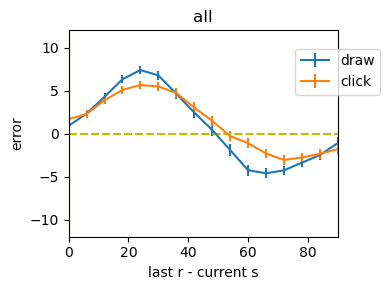

In [47]:
### save the most important results
compare_serial_bias(reorganized, 
    all_conditions_to_compare['compare different modes'], 
    None)

plot_path = os.path.join(
    PLOTS_FOLDER, 'behav_sd_modes.png')
plt.savefig(plot_path, bbox_inches='tight')

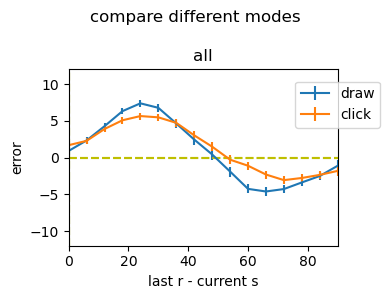

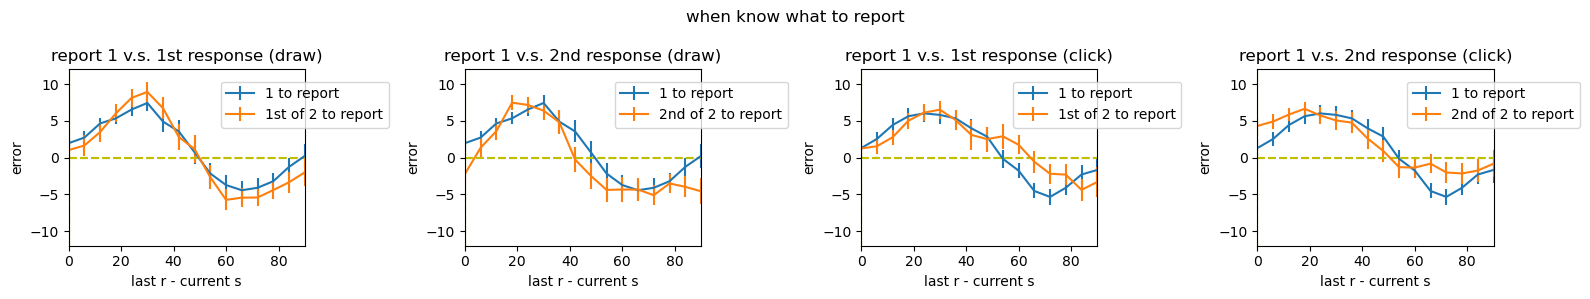

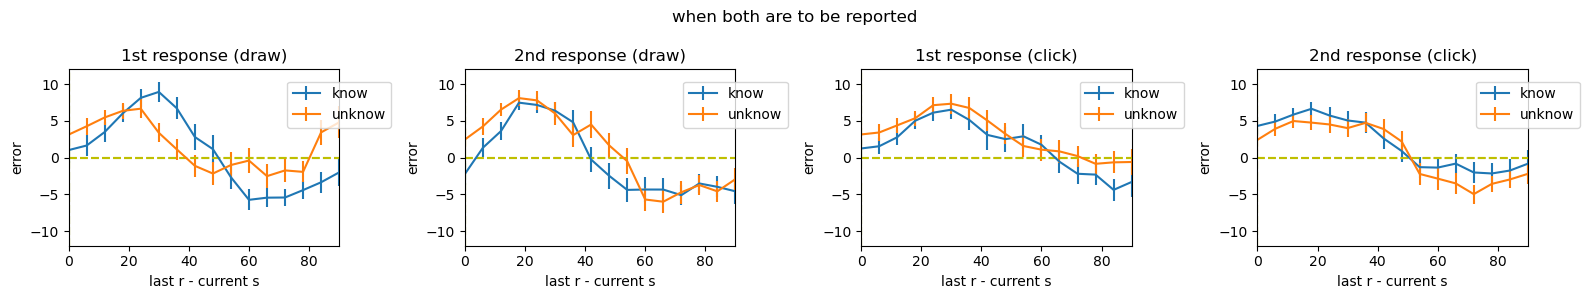

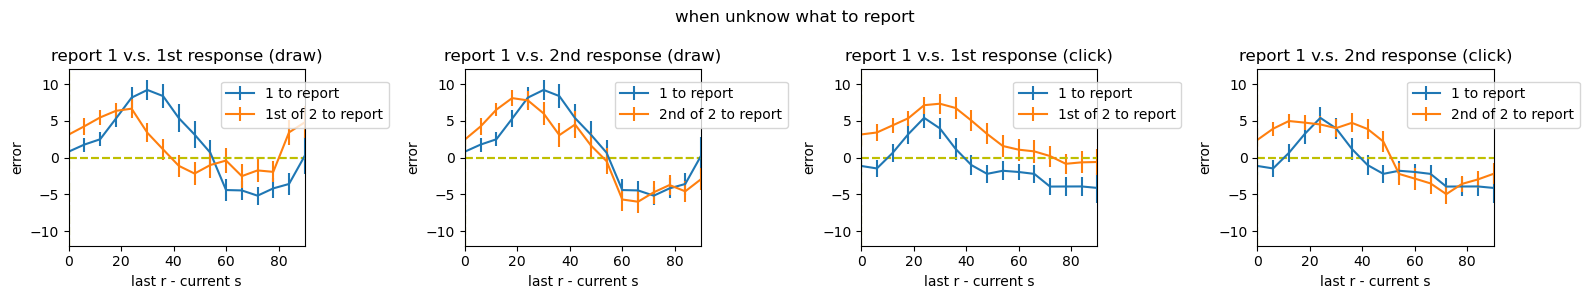

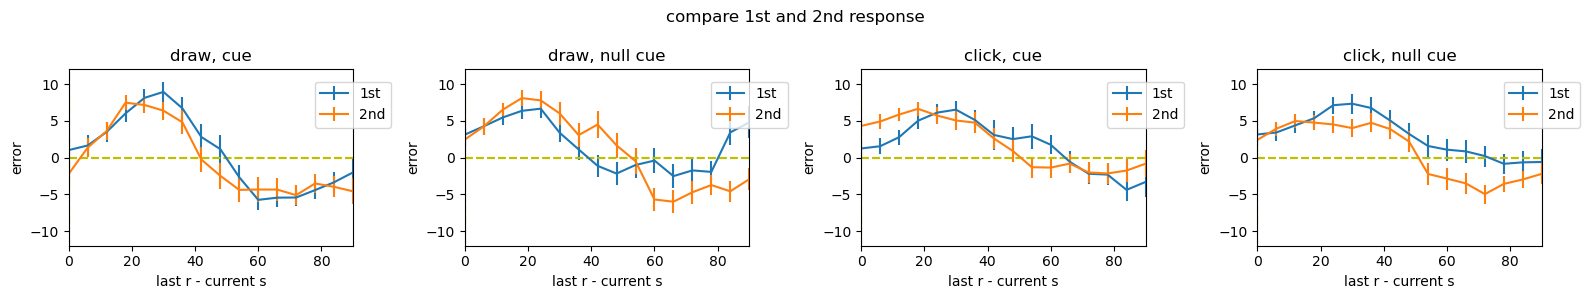

In [41]:
compare_serial_bias_all_conditions(reorganized, all_conditions_to_compare)

### Surrounding bias

In [42]:
def plot_surrounding(ax, df, mask_lambda, label=None):
    binned = plot_bias_curve(ax, df, mask_lambda, 'neighbor_stim', 'stim', 'resp', 'stim', label=label)
    x_label = f'neighbor s - target s'
    ax.set_xlabel(x_label)
    return binned

In [43]:
def compare_surrounding_bias(df, masks_list, sup_title):
    nc = len(masks_list)
    fig, axs = plt.subplots(1, nc, figsize=(4*nc, 3))
    for i, title in enumerate(list(masks_list.keys())):
        ax = axs[i] if nc > 1 else axs
        masks = masks_list[title]
        n_data = {}
        for label, mask in masks.items():
            processed = plot_surrounding(ax, df, mask, label=label)
            n_data[label] = processed['n_total']
        ax.set_title(title)
        ax.legend(bbox_to_anchor=[1.0, 0.8], loc='center')
        # print(f'{title} -- {n_data}')
        
    plt.suptitle(sup_title)
    plt.tight_layout()

In [44]:
def compare_surrounding_bias_all_conditions(df, all_mask_lists):
    for analysis_name, analysis_masks in all_mask_lists.items():
        compare_surrounding_bias(df, analysis_masks, analysis_name)

#### Run all analysis on current batch

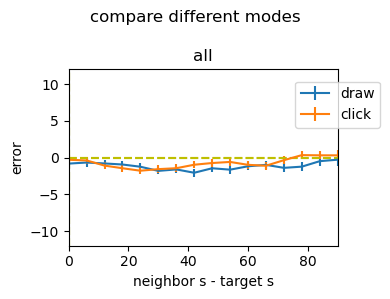

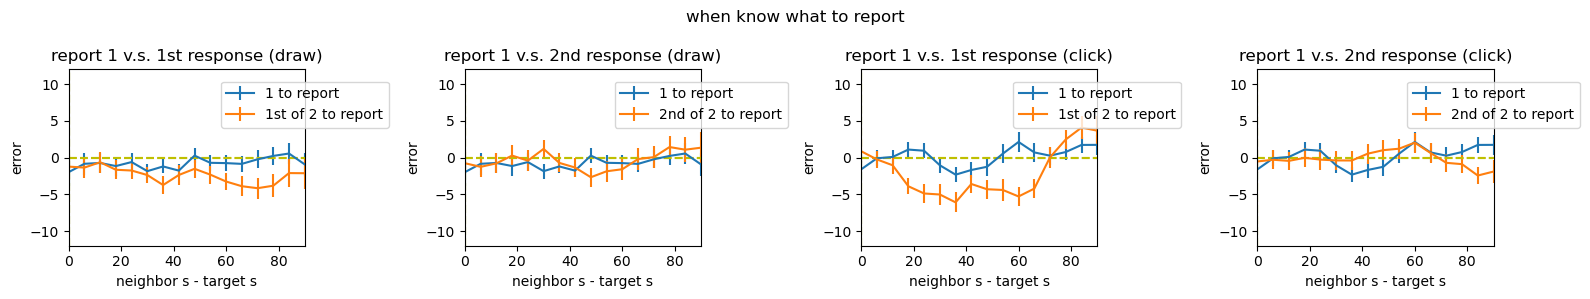

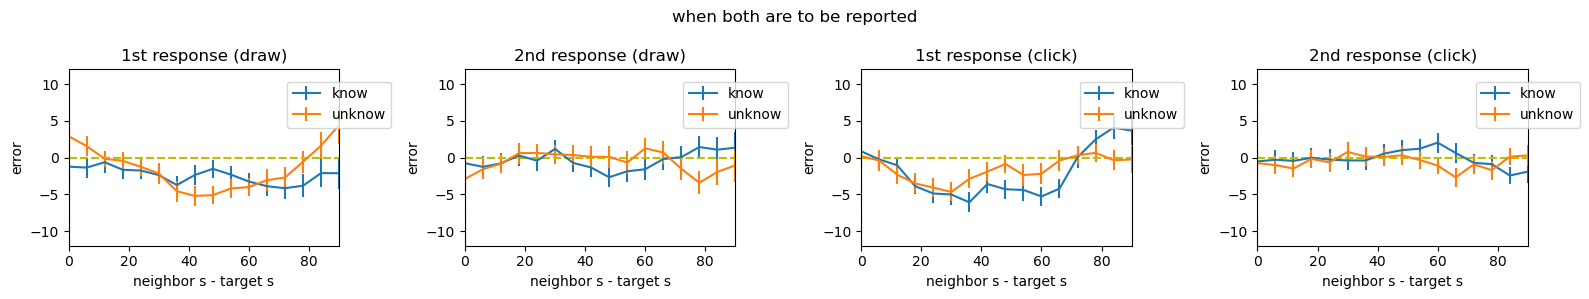

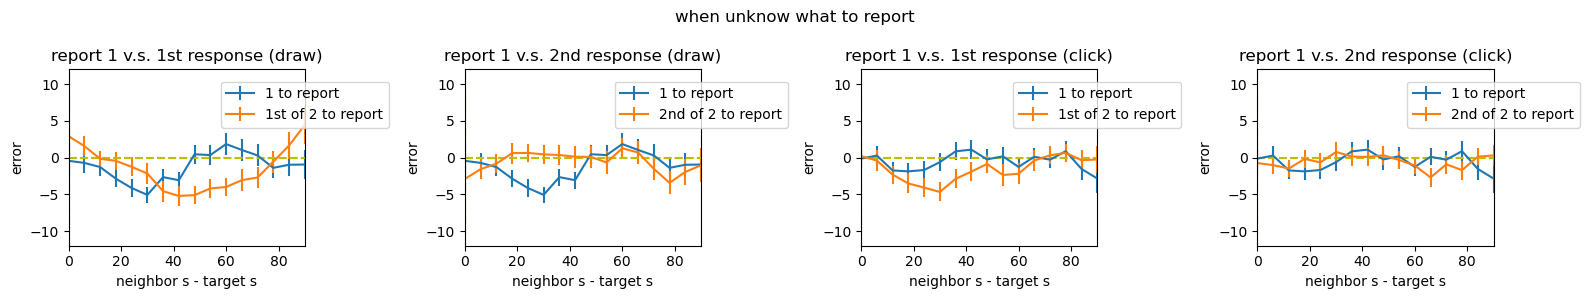

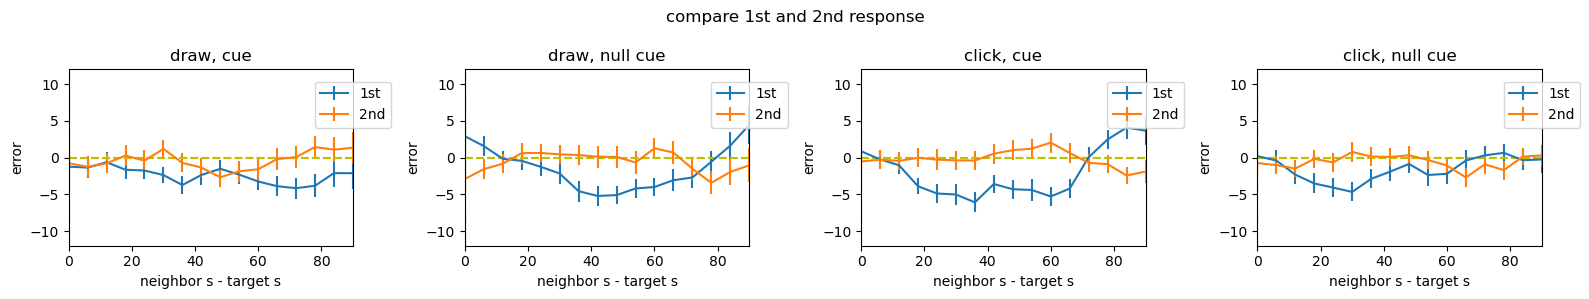

In [45]:
compare_surrounding_bias_all_conditions(reorganized, all_conditions_to_compare)